<h1>
    Thermodynamics of Materials AD19: <br>
    <b>Class Activity 03</b>
</h1>

<table width="75%" align="center">
    <tr>
        <th align="left" colspan="2">
            <h2><b>Team<b>:</b></h2>
        </th>
    </tr>
    <tr>
        <td><h3>Antonio Osamu Katagiri Tanaka</h3></td>
        <td><h4>A01212611@itesm.mx</h4></td>
    </tr>
    <tr>
        <td><h3>Diego Sebastián Ceciliano Franco</h3></td>
        <td><h4>A01373414@itesm.mx</h4></td>
    </tr>
    <tr>
        <td><h3>Jesús Alberto Martínez Espinosa</h3></td>
        <td><h4>a01750270@itesm.mx</h4></td>
    </tr>
</table>

---

<h1>Binary Phase Diagrams</h1>

In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)

from scipy.optimize import least_squares, fsolve, curve_fit

$$ \Delta G_{m,A} = 8000 - 10 T [J/mol] $$
$$ \Delta G_{m,B} = 12000 - 10 T [J/mol] $$

In [2]:
def DG_mA_(T):
    return 8000 - 10*T;

def DG_mB_(T):
    return 12000 - 10*T;

$$ \Omega_l = -20000 [J/mol] $$
$$ \Omega_s = 0 [J/mol] $$

In [3]:
Omega_l = -20000
Omega_s = 0

$$ \Delta G_s = - x_A \Delta G_{m,A} + R T (x_A ln x_A + x_B ln x_B) + \Omega_s x_A x_B  $$
$$ \Delta G_l = x_B \Delta G_{m,B} + R T (x_A ln x_A + x_B ln x_B) + \Omega_l x_A x_B $$

$$ G_{B,s} = 0 $$
$$ G_{A,l} = 0 $$

Substituing numerical values ...

$$ \Delta G_s = R T (x_A ln x_A + x_B ln x_B) $$
$$ \frac{d \Delta G_s}{d x_B} = R T (ln x_B - ln x_A) $$

$$ \Delta G_l = (12000 - 10 T) x_B + (8000 - 10 T) x_A + R T (x_A ln x_A + x_B ln x_B) - 20000 x_A x_B $$
$$ \frac{d \Delta G_l}{d x_B} = 4000 - 20000 x_A + 20000 x_B + R T (ln x_B - ln x_A) $$

In [4]:
def DG_s_(xb, T):
    R = 8.3144
    xa = 1 - xb
    return R*T*(xa*np.log(xa) + xb*np.log(xb))

def d_DG_s_(xb, T):
    R = 8.3144
    xa = 1 - xb
    return R*T*(np.log(xb) - np.log(xa))


def DG_l_(xb, T):
    R = 8.3144
    xa = 1 - xb
    return (12000 - 10*T)*xb + (8000 - 10*T)*xa + R*T*(xa*np.log(xa) + xb*np.log(xb)) - 20000*xa*xb

def d_DG_l_(xb, T):
    R = 8.3144
    xa = 1 - xb
    return 4000 - 20000*(1-xb) + 20000*xb + R*T*(np.log(xb) - np.log(xa))

The tangents are depicted as:

```python
    y_tan_l = d_DG_l_(xl0, T) * (xb - xl0) + DG_l_(xl0, T)
    y_tan_s = d_DG_s_(xs0, T) * (xb - xs0) + DG_s_(xs0, T)
```

function
```python
    phaseDiagram
```
is to find the common tangent(s), $y_{tan,l} = y_{tan,s}$ at $x_B = 0$. So, let's find some $x_{l,0}$ and $x_{s,0}$ to satisfy that:
```python
    d_DG_l_(x1, T) - d_DG_s_(x2, T) = 0
    d_DG_l_(x1, T)*(x1 - x2) - (DG_l_(x1, T) - DG_s_(x2, T)) = 0
```

---
Get compositions in equilibrium from a given temperature

In [5]:
def phaseDiagram(T):
    #y_tan_l = d_DG_l_(xl0, T) * (xb - xl0) + DG_l_(xl0, T)
    #y_tan_s = d_DG_s_(xs0, T) * (xb - xs0) + DG_s_(xs0, T)

    f1  = lambda x:   DG_l_(x, T)
    df1 = lambda x: d_DG_l_(x, T)
    f2  = lambda x:   DG_s_(x, T)
    df2 = lambda x: d_DG_s_(x, T)

    def eqns(x):
        x1, x2 = x[0], x[1]
        eq1 = df1(x1) - df2(x2)
        eq2 = df1(x1)*(x1 - x2) - (f1(x1) - f2(x2))
        return [eq1, eq2]

    from scipy.optimize import least_squares
    lowerbound = 0.0000001
    upperbound = 0.9999999
    lb = (lowerbound, lowerbound) # lower bounds on x1, x2
    ub = (upperbound, upperbound) # upper bounds

    x0 = least_squares(eqns, [0.1, 0.1], bounds=(lb, ub)) # liquid xs
    x1 = least_squares(eqns, [0.9, 0.9], bounds=(lb, ub)) # solid xs
    
    #print(x0.x, x1.x)
    return x0.x[0], x0.x[1], x1.x[0], x1.x[1]

# PLOT Gibbs Curves

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

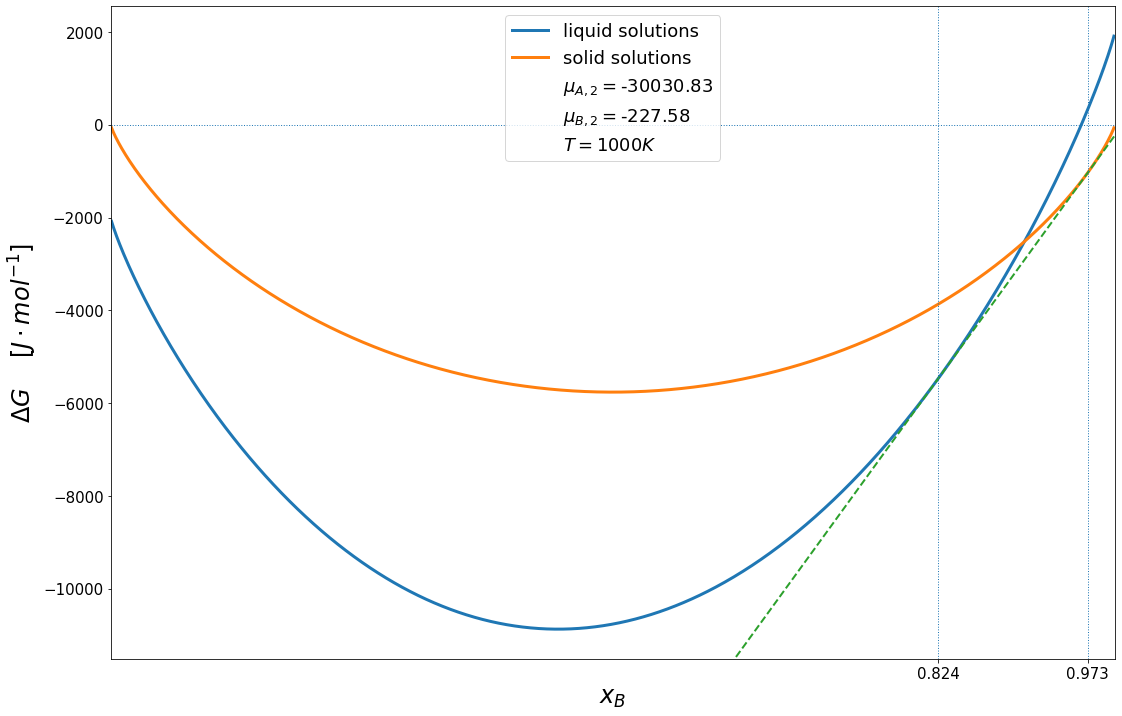

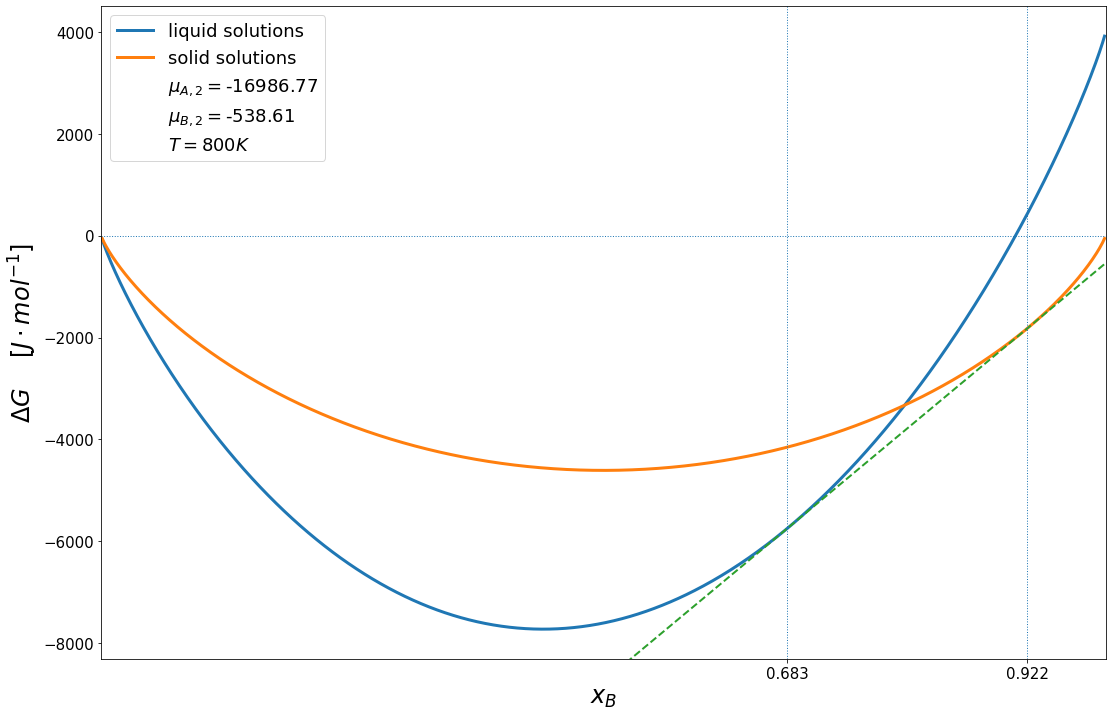

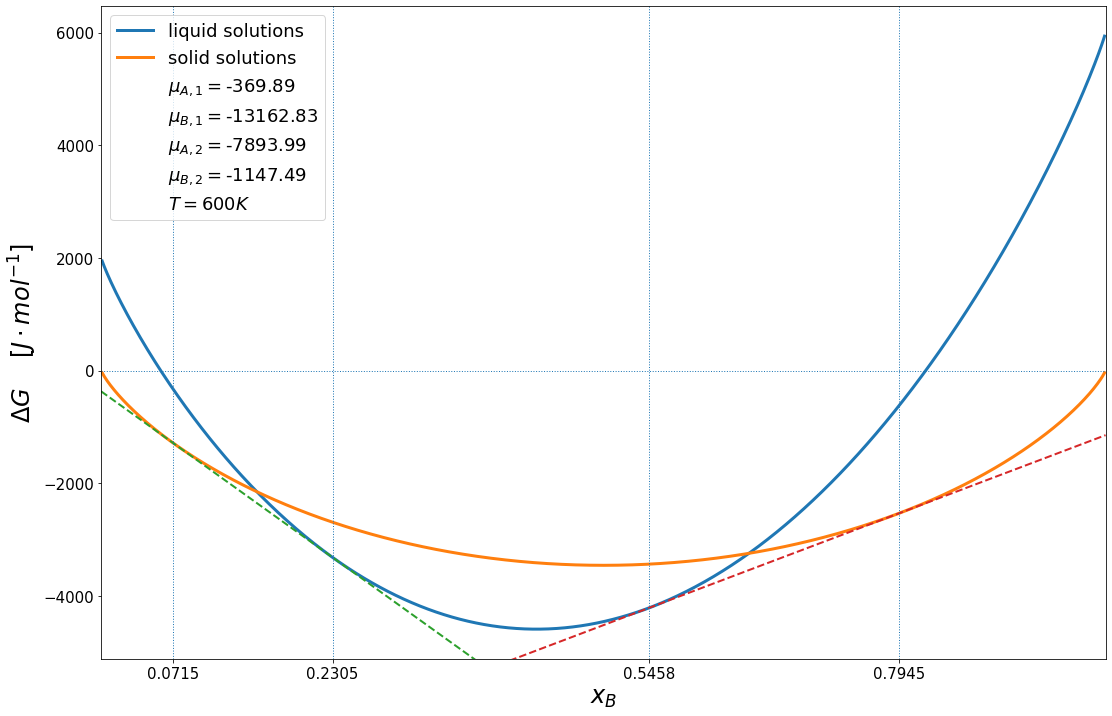

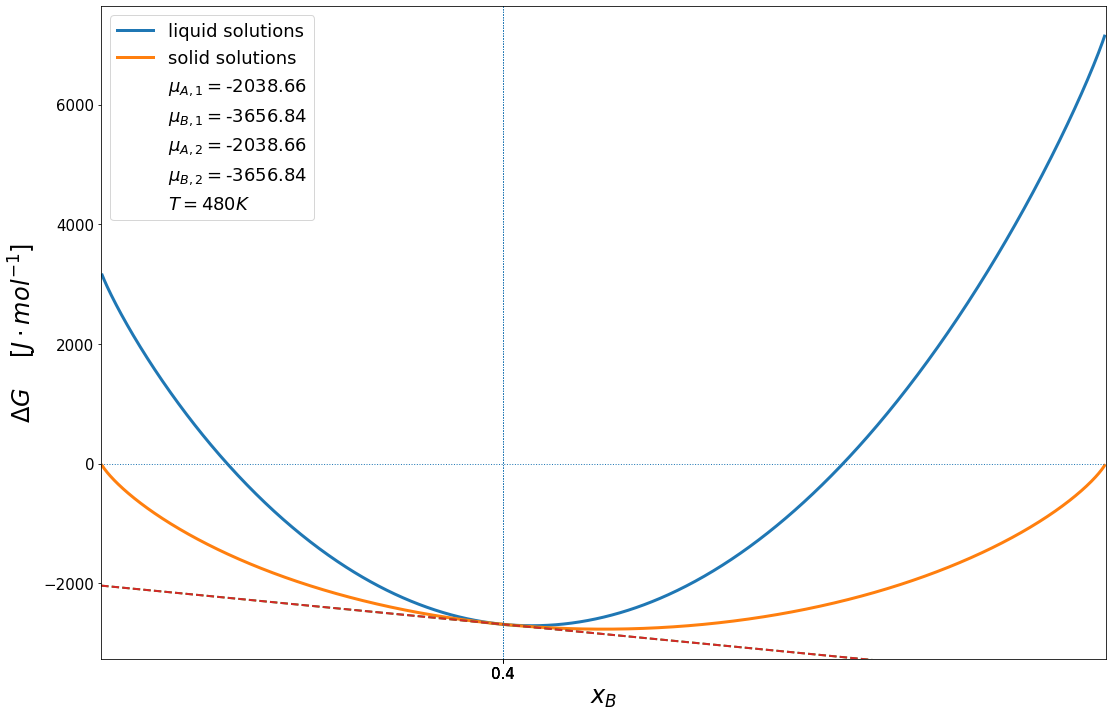

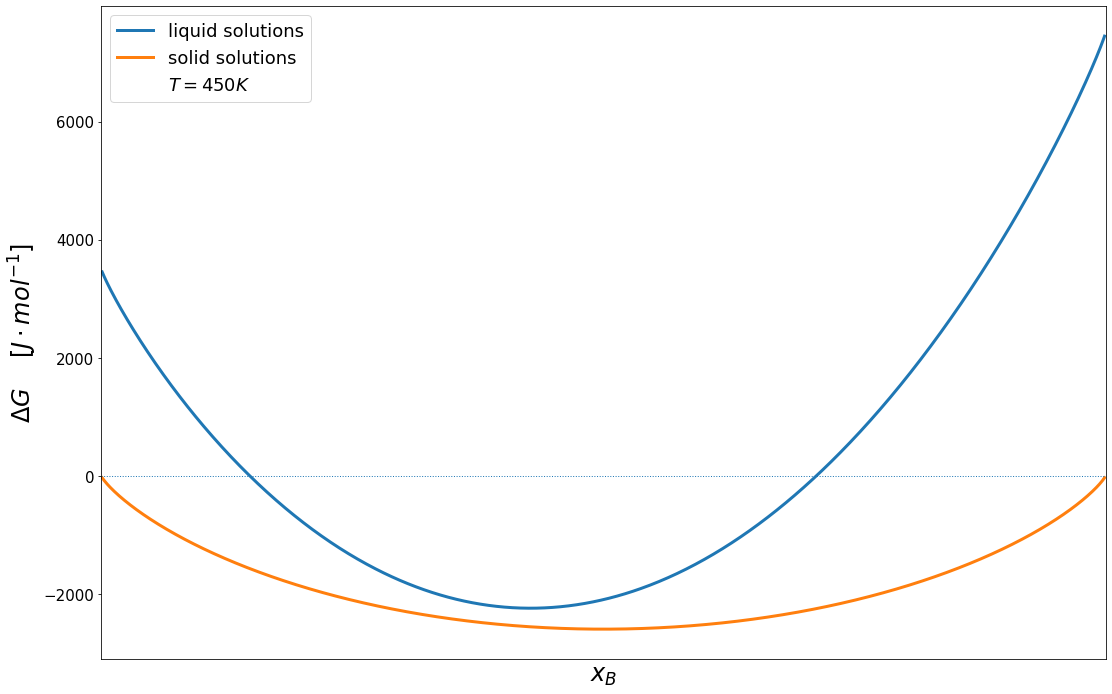

In [6]:
def gibbsCurves(T):
    xb = np.linspace(0.0, 1.0, 1000)
    comp = phaseDiagram(T);

    # PLOT FIG
    scale = 6;
    fig, ax = plt.subplots(figsize=(3*scale, 2*scale));

    # Plot
    #plt.scatter(T, C, s=25, color='red', label='Raw data');
    x = xb
    yl = DG_l_(xb, T)
    plt.plot(x, yl, '-', linewidth=3, label='liquid solutions')

    x = xb
    ys = DG_s_(xb, T)
    plt.plot(x, ys, '-', linewidth=3, label='solid solutions')

    # A,}JXJJHYy*pVeM6
    ax.set(autoscale_on=False)
    ax.set_xticks(ax.get_xticks()[::100]) # remove unnecessary ticks
    ax.ticklabel_format(useOffset=False)  # disable scientific notation
    plt.axhline(y=0, linestyle=':', linewidth=1)

    # plot tangents
    lowerbound = 0.0000001
    upperbound = 0.9999999

    if (round(comp[0],3) > lowerbound and round(comp[1],3) < upperbound):
        # plot tangents
        y_tan_l = d_DG_l_(comp[0], T) * (xb - comp[0]) + DG_l_(comp[0], T)
        y_tan_s = d_DG_s_(comp[1], T) * (xb - comp[1]) + DG_s_(comp[1], T)
        if round(y_tan_l[0],2) == round(y_tan_s[0],2):
            plt.plot(x, y_tan_l, '--', linewidth=2)
            #plt.plot(x, y_tan_s, '--', linewidth=2)
            # add values as ticks
            extraticks=[comp[0], comp[1]]
            plt.xticks(list(plt.xticks()[0]) + extraticks)
            plt.axvline(x=comp[0], linestyle=':', linewidth=1)
            plt.axvline(x=comp[1], linestyle=':', linewidth=1)
            # add chemical potentials as legend
            plt.scatter(xb[0], yl[0], s=0, label=r'$\mu_{A,1} = $' + str(round(y_tan_l[0], 2)))
            plt.scatter(xb[0], yl[0], s=0, label=r'$\mu_{B,1} = $' + str(round(y_tan_l[len(y_tan_l)-1], 2)))

    if (round(comp[2],3) > lowerbound and round(comp[3],3) < upperbound):
        # plot tangents
        y_tan_l = d_DG_l_(comp[2], T) * (xb - comp[2]) + DG_l_(comp[2], T)
        y_tan_s = d_DG_s_(comp[3], T) * (xb - comp[3]) + DG_s_(comp[3], T)
        if round(y_tan_l[0],2) == round(y_tan_s[0],2):
            plt.plot(x, y_tan_l, '--', linewidth=2)
            #plt.plot(x, y_tan_s, '--', linewidth=2)
            # add compositions as ticks
            extraticks=[comp[2], comp[3]]
            plt.xticks(list(plt.xticks()[0]) + extraticks)
            plt.axvline(x=comp[2], linestyle=':', linewidth=1)
            plt.axvline(x=comp[3], linestyle=':', linewidth=1)
            # add chemical potentials as legend
            plt.scatter(xb[0], yl[0], s=0, label=r'$\mu_{A,2} = $' + str(round(y_tan_l[0], 2)))
            plt.scatter(xb[0], yl[0], s=0, label=r'$\mu_{B,2} = $' + str(round(y_tan_l[len(y_tan_l)-1], 2)))

    # Print fitting parameters as plot legends
    plt.scatter(xb[0], yl[0], s=0, label=r'$T = $' + str(round(T, 2)) + r'$K$')

    # Display plots
    plt.xlim(0.0, 1.0)
    plt.yscale('linear');
    plt.xlabel(r'$x_B$', fontsize=24);
    plt.ylabel(r'$\Delta G$' + '    ' + r'$[J \cdot mol^{-1}]$', fontsize=24);
    #plt.title('Figure 1', size=24);
    plt.legend(prop={'size': 18});
    display(plt);
    
###############
T = [1000, 800, 600, 480, 450]
for t in T:
    gibbsCurves(t)

# PLOT Phase Diagram

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

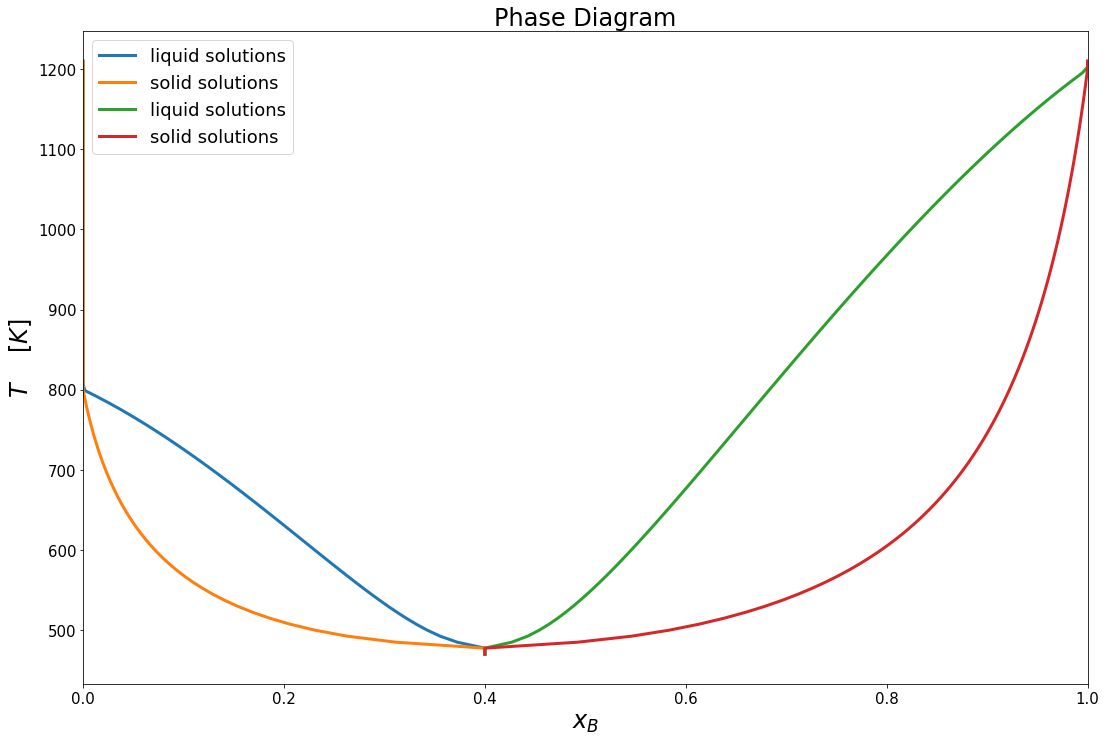

In [7]:
T = np.linspace(470.0, 1210.0, 100)
xb = np.linspace(0.0, 1.0, 100)

comp0 = []
comp1 = []
comp2 = []
comp3 = []
for t in T:
    comp = phaseDiagram(t);
    comp0.append(comp[0])
    comp1.append(comp[1])
    comp2.append(comp[2])
    comp3.append(comp[3])
    
# PLOT FIG
scale = 6;
fig, ax = plt.subplots(figsize=(3*scale, 2*scale));

# Plot
#plt.scatter(T, C, s=25, color='red', label='Raw data');
x = comp0
y = T
plt.plot(x, y, '-', linewidth=3, label='liquid solutions')

x = comp1
y = T
plt.plot(x, y, '-', linewidth=3, label='solid solutions')

x = comp2
y = T
plt.plot(x, y, '-', linewidth=3, label='liquid solutions')

x = comp3
y = T
plt.plot(x, y, '-', linewidth=3, label='solid solutions')

ax.ticklabel_format(useOffset=False)  # disable scientific notation

# Display plots
plt.xlim(0.0, 1.0)
plt.yscale('linear');
plt.xlabel(r'$x_B$', fontsize=24);
plt.ylabel(r'$T$' + '    ' + r'$[K]$', fontsize=24);
plt.title('Phase Diagram', size=24);
plt.legend(prop={'size': 18});
display(plt);

In [8]:
import pdfkit
path_wkthmltopdf = r'C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe'
config = pdfkit.configuration(wkhtmltopdf=path_wkthmltopdf)

options = {
    'page-size': 'A4',
    'margin-top': '0.0in',
    'margin-right': '0.0in',
    'margin-bottom': '0.0in',
    'margin-left': '0.0in',
    'encoding': "UTF-8",
    'custom-header' : [
        ('Accept-Encoding', 'gzip')
    ],
    'cookie': [
        ('cookie-name1', 'cookie-value1'),
        ('cookie-name2', 'cookie-value2'),
    ],
    'no-outline': None,
    'orientation': 'Landscape'
}

pdfkit.from_file('./BinaryPhaseDiagrams.html','BinaryPhaseDiagrams.pdf', configuration=config, options=options)

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                        


True